Import Library

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor 

Read Dataset For SJ

In [53]:
sj_past_path = os.path.join("..", "data", "processed", "sj_past.csv")
sj_future_path = os.path.join("..", "data", "processed", "sj_future.csv")

sj_past = pd.read_csv(sj_past_path, parse_dates=["week_start_date"])
sj_future = pd.read_csv(sj_future_path, parse_dates=["week_start_date"])

In [54]:
sj_past["T_x_RH"]      = sj_past["station_avg_temp_c"] * sj_past["dew_humidity"]
sj_past["Rain_x_T"]    = sj_past["reanalysis_sat_precip_amt_mm"] * sj_past["station_avg_temp_c"]
sj_past["DTR_x_RH"]    = sj_past["station_diur_temp_rng_c"] * sj_past["dew_humidity"]

In [55]:
sj_X_cols = sj_past.select_dtypes("number").columns.drop(["total_cases","year","weekofyear"])
sj_X_raw = sj_past[sj_X_cols].values
sj_y_raw = sj_past[["total_cases"]].values

In [56]:
sj_scaler_X = MinMaxScaler(feature_range=(0,1))
sj_scaler_y = MinMaxScaler(feature_range=(0,1))
sj_X_scaled = sj_scaler_X.fit_transform(sj_X_raw)
sj_y_scaled = sj_scaler_y.fit_transform(sj_y_raw)

LSTM For SJ

Split Dataset

In [57]:
SEQ_LEN = 4         
sj_X_seq, sj_y_seq = [], []
for i in range(len(sj_X_scaled)-SEQ_LEN):
    sj_X_seq.append(sj_X_scaled[i:i+SEQ_LEN])
    sj_y_seq.append(sj_y_scaled[i+SEQ_LEN])
sj_X_seq, sj_y_seq = np.array(sj_X_seq), np.array(sj_y_seq)

sj_seq_split = int(len(sj_X_seq)*0.8)
sj_X_seq_train, sj_X_seq_val = sj_X_seq[:sj_seq_split], sj_X_seq[sj_seq_split:]
sj_y_seq_train, sj_y_seq_val = sj_y_seq[:sj_seq_split], sj_y_seq[sj_seq_split:]

Train and Test Model

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


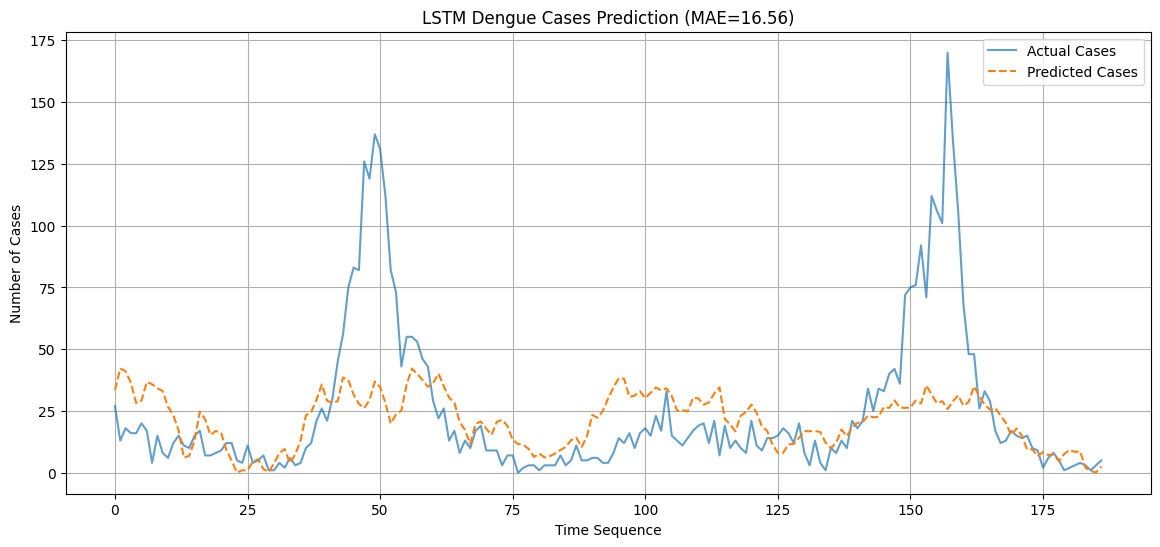

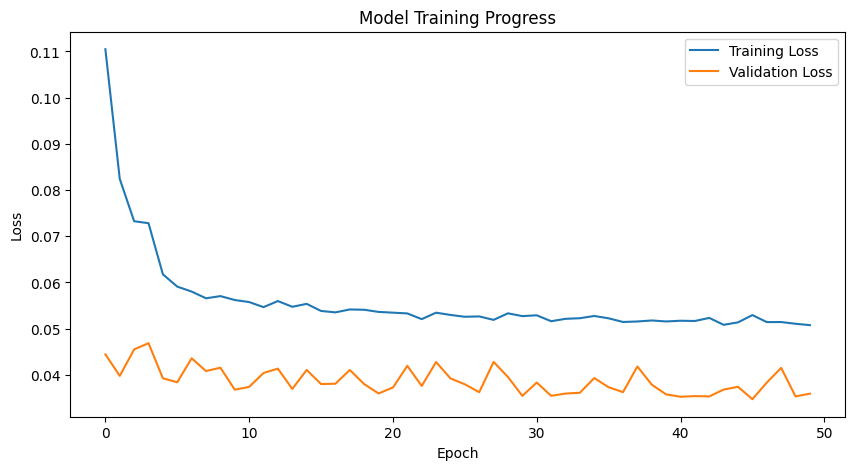

In [58]:
model_sj = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, sj_X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model_sj.compile(loss="mae", optimizer=Adam(0.001))

sj_history = model_sj.fit(
    sj_X_seq_train, sj_y_seq_train,
    epochs=50, batch_size=32,
    validation_data=(sj_X_seq_val, sj_y_seq_val),
    verbose=0
)

sj_lstm_test_predict = model_sj.predict(sj_X_seq_val)

sj_lstm_y_pred = sj_scaler_y.inverse_transform(sj_lstm_test_predict)
sj_lstm_y_true = sj_scaler_y.inverse_transform(sj_y_seq_val.reshape(-1,1))

mae= mean_absolute_error(sj_lstm_y_true, sj_lstm_y_pred)

plt.figure(figsize=(14, 6))
plt.plot(sj_lstm_y_true, label="Actual Cases", alpha=0.7)
plt.plot(sj_lstm_y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"LSTM Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sj_history.history['loss'], label='Training Loss')
plt.plot(sj_history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

XGboost for SJ

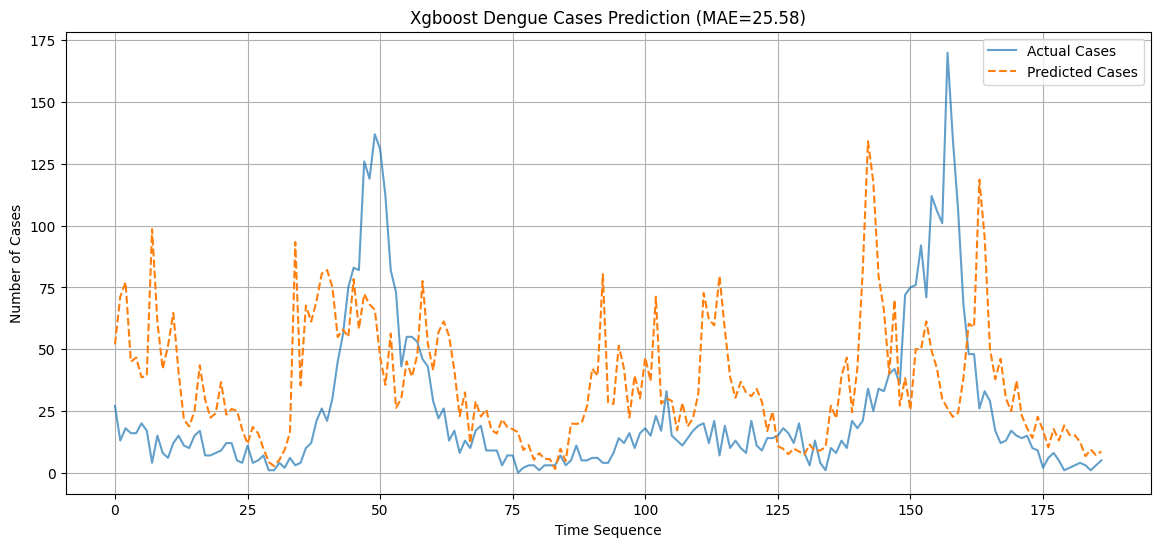

In [59]:
sj_n_samples_tr, sj_seq_len, sj_n_feats = sj_X_seq_train.shape
sj_X_tr_flat  = sj_X_seq_train.reshape(sj_n_samples_tr, sj_seq_len * sj_n_feats)
sj_n_samples_va = sj_X_seq_val.shape[0]
sj_X_val_flat = sj_X_seq_val.reshape(sj_n_samples_va, sj_seq_len * sj_n_feats)

xgb_model_sj = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_model_sj.fit(sj_X_tr_flat, sj_y_seq_train.ravel())


sj_xg_y_pred_scaled = xgb_model_sj.predict(sj_X_val_flat)

sj_xg_y_pred = sj_scaler_y.inverse_transform(sj_xg_y_pred_scaled.reshape(-1, 1)).flatten()
sj_xg_y_true = sj_scaler_y.inverse_transform(sj_y_seq_val.reshape(-1, 1)).flatten()
mae_xg= mean_absolute_error(sj_xg_y_true, sj_xg_y_pred)
plt.figure(figsize=(14, 6))
plt.plot(sj_xg_y_true, label="Actual Cases", alpha=0.7)
plt.plot(sj_xg_y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"Xgboost Dengue Cases Prediction (MAE={mae_xg:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

Poisson For SJ

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  748
Model:                            GLM   Df Residuals:                      726
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16330.
Date:                  周一, 05 5月 2025   Deviance:                       29039.
Time:                        13:59:38   Pearson chi2:                 4.61e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9976
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.6181      2.118      8.320      0.0

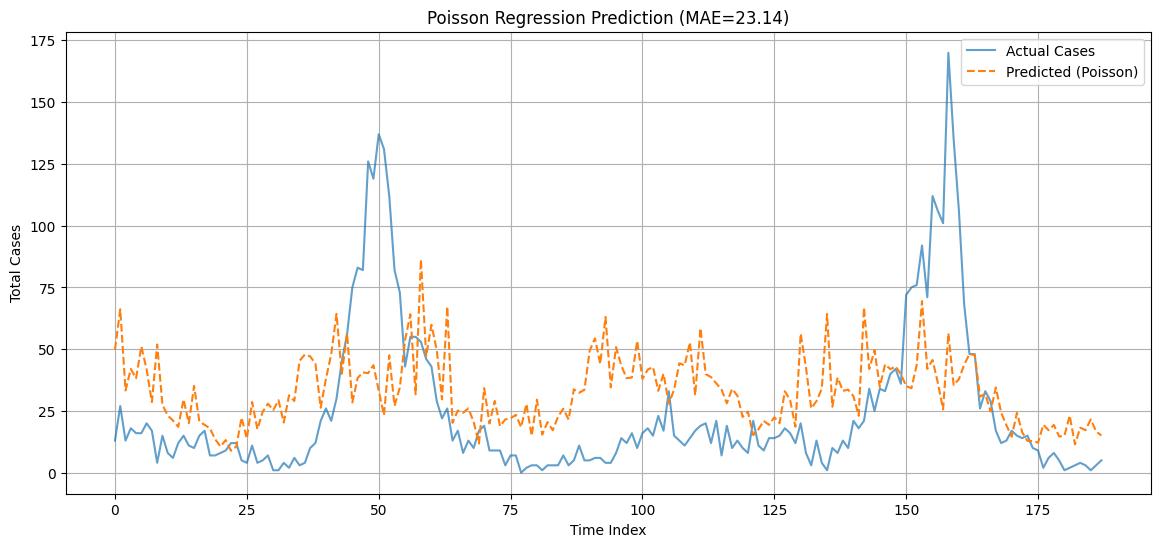

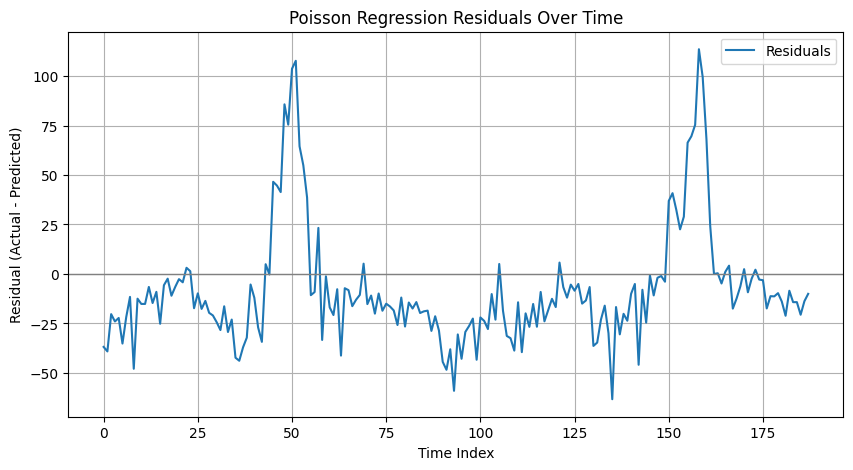

In [60]:
sj_poi_split = int(len(sj_X_scaled) * 0.8)
sj_poi_X_train, sj_poi_y_train = sj_X_scaled[:sj_poi_split], sj_y_raw[:sj_poi_split]
sj_poi_X_val, sj_poi_y_val     = sj_X_scaled[sj_poi_split:], sj_y_raw[sj_poi_split:]

sj_poi_X_train = sm.add_constant(sj_poi_X_train)
sj_poi_X_val   = sm.add_constant(sj_poi_X_val)

sj_poisson_model = sm.GLM(
    sj_poi_y_train,
    sj_poi_X_train, 
    family=sm.families.Poisson()
).fit()
print(sj_poisson_model .summary())

sj_poi_y_pred = sj_poisson_model.predict(sj_poi_X_val)
mae = mean_absolute_error(sj_poi_y_val, sj_poi_y_pred)

plt.figure(figsize=(14,6))
plt.plot(sj_poi_y_val,    label="Actual Cases", alpha=0.7)
plt.plot(sj_poi_y_pred,   label="Predicted (Poisson)", linestyle="--")
plt.title(f"Poisson Regression Prediction (MAE={mae:.2f})")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend(); plt.grid(True)
plt.show()

residuals = sj_poi_y_val - sj_poi_y_pred.reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color="gray", linewidth=1)
plt.title("Poisson Regression Residuals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.legend(); plt.grid(True)
plt.show()


Read Dataset for IQ

In [61]:
iq_past_path = os.path.join("..", "data", "processed", "iq_past.csv")
iq_future_path = os.path.join("..", "data", "processed", "iq_future.csv")

iq_past = pd.read_csv(iq_past_path, parse_dates=["week_start_date"])
iq_future = pd.read_csv(iq_future_path, parse_dates=["week_start_date"])

In [62]:
iq_past["T_x_RH"]      = iq_past["station_avg_temp_c"] * iq_past["dew_humidity"]
iq_past["Rain_x_T"]    = iq_past["reanalysis_sat_precip_amt_mm"] * iq_past["station_avg_temp_c"]
iq_past["DTR_x_RH"]    = iq_past["station_diur_temp_rng_c"] * iq_past["dew_humidity"]

In [63]:
iq_X_cols = iq_past.select_dtypes("number").columns.drop(["total_cases","year","weekofyear"])
iq_X_raw = iq_past[iq_X_cols].values
iq_y_raw = iq_past[["total_cases"]].values

In [64]:
scaler_X_iq = MinMaxScaler(feature_range=(0,1))
scaler_y_iq = MinMaxScaler(feature_range=(0,1))
iq_X_scaled = scaler_X_iq.fit_transform(iq_X_raw)
iq_y_scaled = scaler_y_iq.fit_transform(iq_y_raw)

LSTM for IQ

Split Dataset

In [65]:
SEQ_LEN = 4          
iq_X_seq, iq_y_seq = [], []
for i in range(len(iq_X_scaled)-SEQ_LEN):
    iq_X_seq.append(iq_X_scaled[i:i+SEQ_LEN])
    iq_y_seq.append(iq_y_scaled[i+SEQ_LEN])
iq_X_seq, iq_y_seq = np.array(iq_X_seq), np.array(iq_y_seq)

iq_seq_split = int(len(iq_X_seq)*0.8)
iq_seq_X_train, iq_seq_X_val = iq_X_seq[:iq_seq_split], iq_X_seq[iq_seq_split:]
iq_seq_y_train, iq_seq_y_val = iq_y_seq[:iq_seq_split], iq_y_seq[iq_seq_split:]

Train and Test Model

c:\Users\13084\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


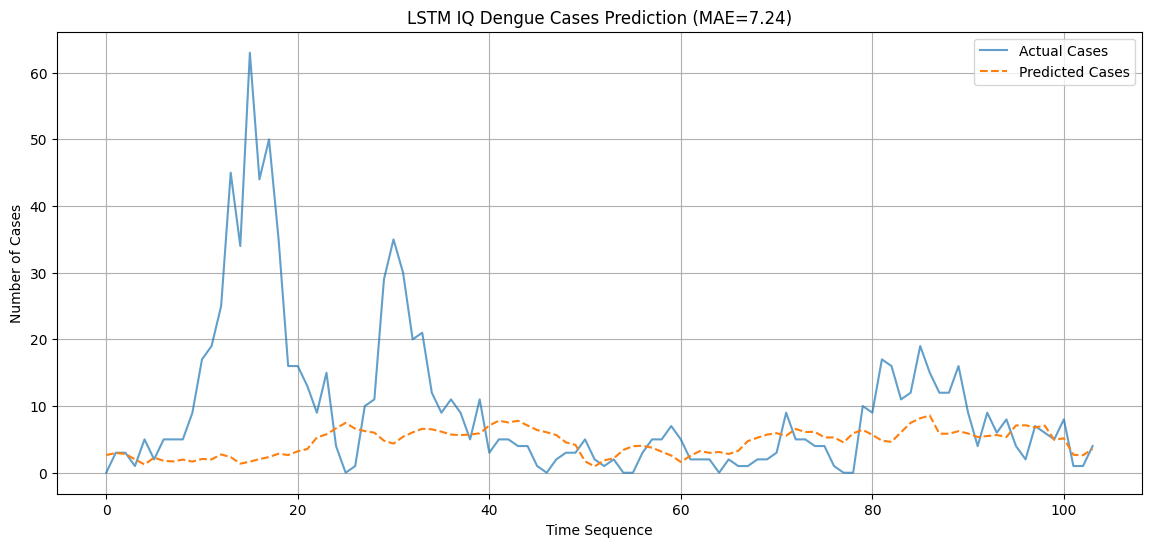

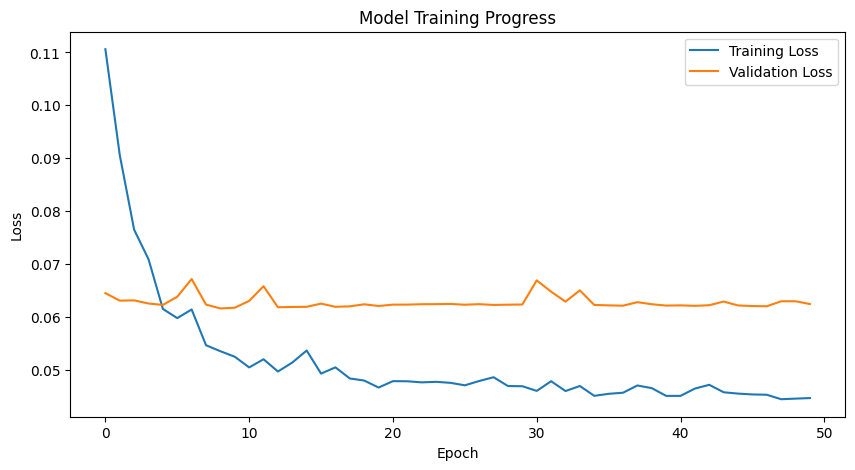

In [66]:
model_iq = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, iq_X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
model_iq.compile(loss="mae", optimizer=Adam(0.001))

iq_history = model_iq.fit(
    iq_seq_X_train, iq_seq_y_train,
    epochs=50, batch_size=32,
    validation_data=(iq_seq_X_val, iq_seq_y_val),
    verbose=0
)

iq_lstm_test_predict = model_iq.predict(iq_seq_X_val)

iq_lstm_y_pred = scaler_y_iq.inverse_transform(iq_lstm_test_predict)
iq_lstm_y_true = scaler_y_iq.inverse_transform(iq_seq_y_val.reshape(-1,1))

mae = mean_absolute_error(iq_lstm_y_true, iq_lstm_y_pred)

plt.figure(figsize=(14, 6))
plt.plot(iq_lstm_y_true, label="Actual Cases", alpha=0.7)
plt.plot(iq_lstm_y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"LSTM IQ Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(iq_history.history['loss'], label='Training Loss')
plt.plot(iq_history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

XGboost for IQ

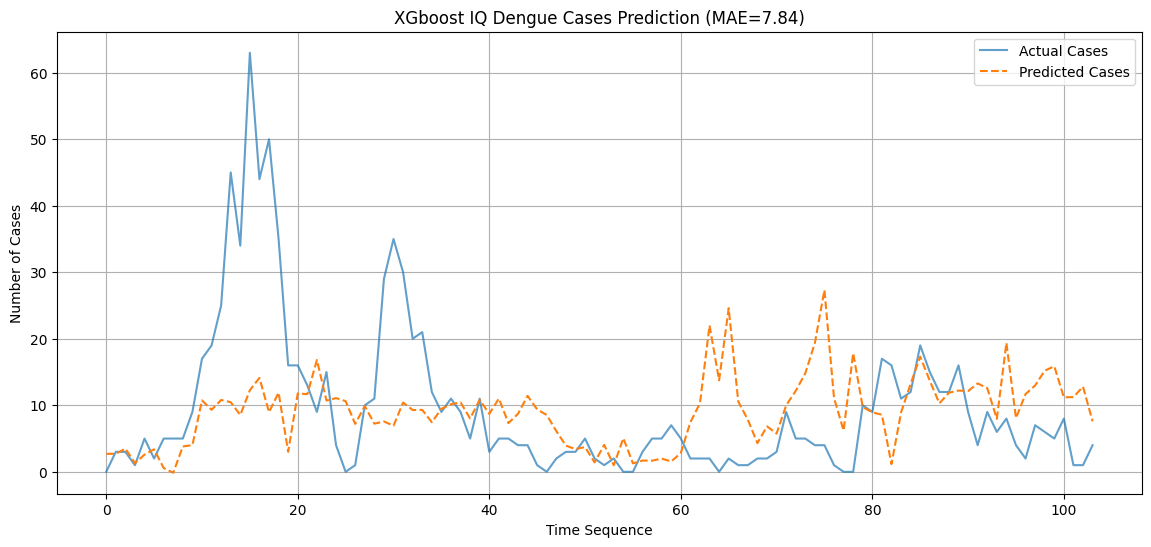

In [67]:
iq_n_samples_tr, iq_seq_len, iq_n_feats = iq_seq_X_train.shape
iq_X_tr_flat  = iq_seq_X_train.reshape(iq_n_samples_tr, iq_seq_len * iq_n_feats)
iq_n_samples_va = iq_seq_X_val.shape[0]
iq_X_val_flat = iq_seq_X_val.reshape(iq_n_samples_va, iq_seq_len * iq_n_feats)

# 2. XGBoost
xgb_model_iq = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_model_iq.fit(iq_X_tr_flat, iq_seq_y_train.ravel())

iq_xg_y_pred_scaled = xgb_model_iq.predict(iq_X_val_flat)

iq_xg_y_pred = scaler_y_iq.inverse_transform(iq_xg_y_pred_scaled.reshape(-1, 1)).flatten()
iq_xg_y_true = scaler_y_iq.inverse_transform(iq_seq_y_val.reshape(-1, 1)).flatten()

mae = mean_absolute_error(iq_xg_y_true, iq_xg_y_pred)

plt.figure(figsize=(14, 6))
plt.plot(iq_xg_y_true, label="Actual Cases", alpha=0.7)
plt.plot(iq_xg_y_pred, label="Predicted Cases", linestyle='--')
plt.title(f"XGboost IQ Dengue Cases Prediction (MAE={mae:.2f})")
plt.xlabel("Time Sequence")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.show()

Poisson For IQ

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  416
Model:                            GLM   Df Residuals:                      394
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2327.5
Date:                  周一, 05 5月 2025   Deviance:                       3475.5
Time:                        13:59:43   Pearson chi2:                 4.69e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8272
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2034      2.881      1.806      0.0

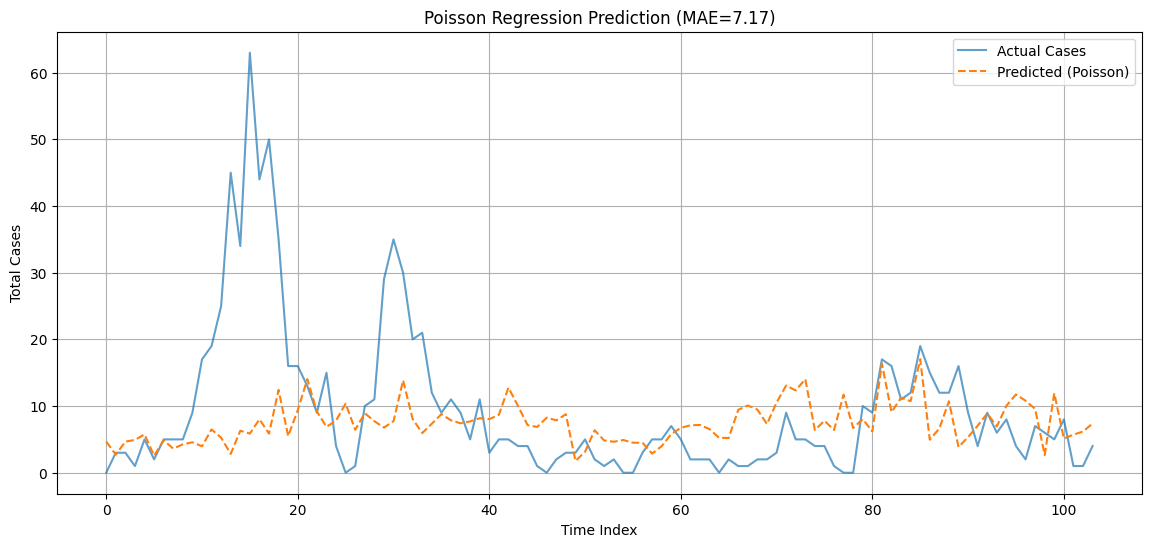

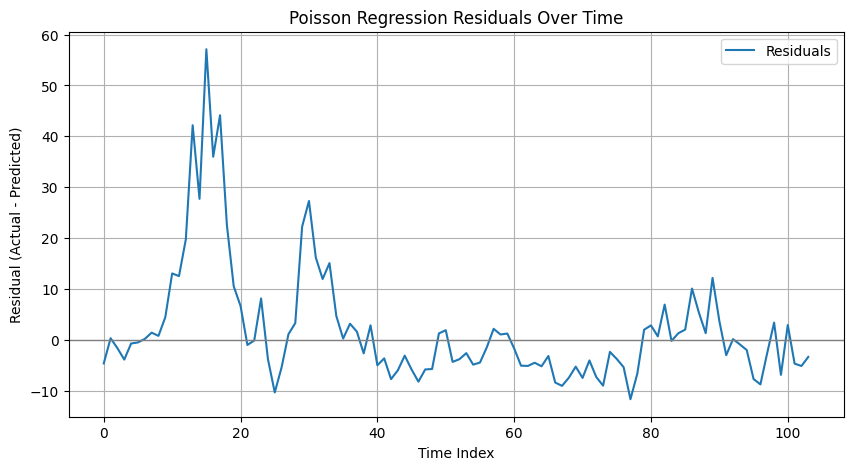

In [68]:
iq_poi_split = int(len(iq_X_scaled) * 0.8)
iq_poi_X_train, iq_poi_y_train = iq_X_scaled[:iq_poi_split], iq_y_raw[:iq_poi_split]
iq_poi_X_val, iq_poi_y_val     = iq_X_scaled[iq_poi_split:], iq_y_raw[iq_poi_split:]

iq_poi_X_train = sm.add_constant(iq_poi_X_train)
iq_poi_X_val   = sm.add_constant(iq_poi_X_val)

iq_poisson_model = sm.GLM(
    iq_poi_y_train,
    iq_poi_X_train, 
    family=sm.families.Poisson()
).fit()
print(iq_poisson_model .summary())

iq_poi_y_pred = iq_poisson_model.predict(iq_poi_X_val)
mae = mean_absolute_error(iq_poi_y_val, iq_poi_y_pred)

plt.figure(figsize=(14,6))
plt.plot(iq_poi_y_val,    label="Actual Cases", alpha=0.7)
plt.plot(iq_poi_y_pred,   label="Predicted (Poisson)", linestyle="--")
plt.title(f"Poisson Regression Prediction (MAE={mae:.2f})")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend(); plt.grid(True)
plt.show()

residuals = iq_poi_y_val - iq_poi_y_pred.reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color="gray", linewidth=1)
plt.title("Poisson Regression Residuals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.legend(); plt.grid(True)
plt.show()